In [44]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile
from td_utils import *

In [45]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('../data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
1097 

activate[1] len: different `activate` clips can have different lengths
1097 



In [46]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [47]:
# UNQ_C1
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    ### END CODE HERE ###

    return overlap

In [48]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [49]:
# UNQ_C2
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
    ### END CODE HERE ###
        #print(segment_time)
    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
    ### START CODE HERE ### 
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)
    ### END CODE HERE ###
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        #print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

In [50]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2254, 3350)


In [51]:
# UNQ_C3
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        ### START CODE HERE ### (≈ 3 lines)
        for i in range(segment_end_y + 1, min(segment_end_y + 51, Ty)):
            if i < Ty:
                y[0, i] = 1
        ### END CODE HERE ###
    
    return y

sanity checks: 0.0 1.0 0.0


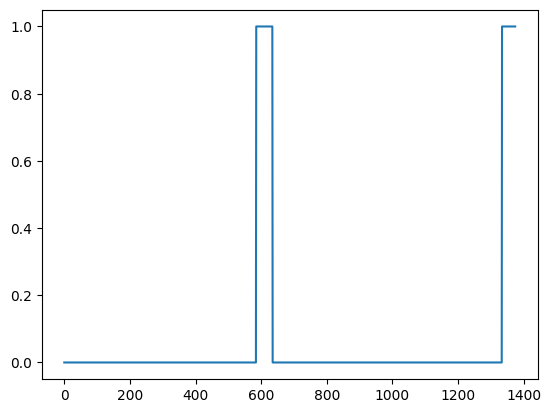

In [52]:
Tx = 5511
Ty = 1375
N_FREQ = 101
SAMPLE_SIZE = 100 # <-- change this directly if needed
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [55]:
# UNQ_C4
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for one_random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time =  insert_audio_clip(background, one_random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("../audio/generated/train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

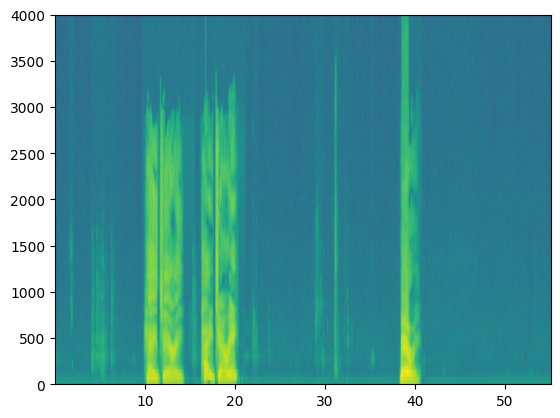

In [56]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

In [57]:
IPython.display.Audio("../audio/generated/train.wav")

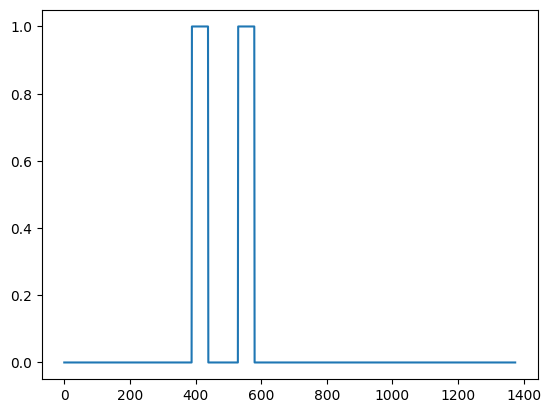

In [58]:
plt.plot(y[0])

0
10
20
30
(32, 5511, 101)
(32, 1375, 1)


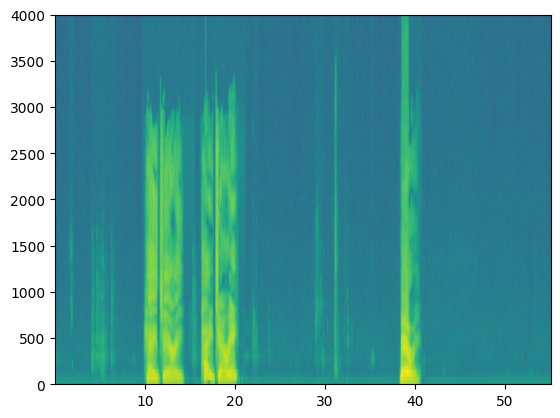

In [59]:
# START SKIP FOR GRADING
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
# END SKIP FOR GRADING

In [61]:
# Save the data for further uses
np.save(f'../data/processed/train/X.npy', X)
np.save(f'../data/processed/train/Y.npy', Y)


0
(4, 5511, 101)
(4, 1375, 1)


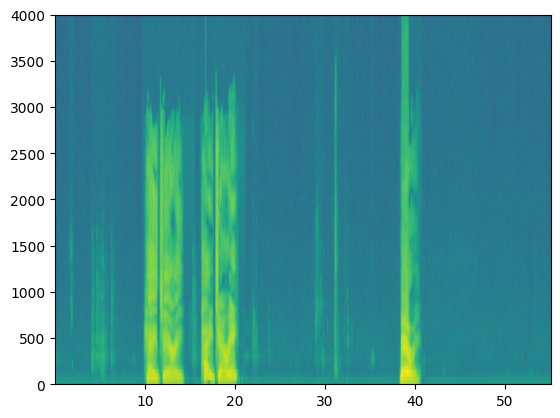

In [62]:
# START SKIP FOR GRADING
np.random.seed(4543)
nsamples = 4
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
# END SKIP FOR GRADING

In [63]:
# Save the data for further uses
np.save(f'../data/processed/dev/X.npy', X)
np.save(f'../data/processed/dev/Y.npy', Y)

In [64]:
# Load the preprocessed training examples
X = np.load("../data/processed/train/X.npy")
Y = np.load("../data/processed/train/Y.npy")

print(X.shape)
print(Y.shape)

(32, 5511, 101)
(32, 1375, 1)


In [65]:
# Load the preprocessed training examples
X = np.load("../data/processed/dev/X.npy")
Y = np.load("../data/processed/dev/Y.npy")

print(X.shape)
print(Y.shape)

(4, 5511, 101)
(4, 1375, 1)


In [1]:
# Wake Word Detection - Training Data Generation
# This notebook creates synthetic training data for wake word detection by overlaying
# "activate" audio clips and negative samples onto background noise

# ============================================================================
# SECTION 1: Setup and Imports
# ============================================================================

import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile
from td_utils import *

# Set plotting style
plt.style.use('default')
%matplotlib inline

In [2]:
# ============================================================================
# SECTION 2: Load Audio Data
# ============================================================================

print("Loading audio segments...")
activates, negatives, backgrounds = load_raw_audio('../data/')

print("\n" + "="*60)
print("AUDIO DATA STATISTICS")
print("="*60)
print(f"Background length: {len(backgrounds[0])} ms (should be ~10,000 ms)")
print(f"Activate[0] length: {len(activates[0])} ms (typically ~1000 ms)")
print(f"Activate[1] length: {len(activates[1])} ms (varies per clip)")
print("="*60 + "\n")

Loading audio segments...

AUDIO DATA STATISTICS
Background length: 10000 ms (should be ~10,000 ms)
Activate[0] length: 1019 ms (typically ~1000 ms)
Activate[1] length: 1097 ms (varies per clip)



In [3]:
# ============================================================================
# SECTION 3: Helper Functions
# ============================================================================

def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Parameters:
        segment_ms (int): Duration of the audio clip in milliseconds
    
    Returns:
        tuple: (segment_start, segment_end) in milliseconds
    """
    # Ensure segment doesn't run past the 10-second background
    segment_start = np.random.randint(low=0, high=10000 - segment_ms)
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)


def is_overlapping(segment_time, previous_segments):
    """
    Checks if a new segment overlaps with any existing segments.
    
    Parameters:
        segment_time (tuple): (segment_start, segment_end) for the new segment
        previous_segments (list): List of (segment_start, segment_end) tuples
    
    Returns:
        bool: True if overlap exists, False otherwise
    """
    segment_start, segment_end = segment_time
    overlap = False
    
    for previous_start, previous_end in previous_segments:
        # Check if segments overlap
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    
    return overlap


# Test overlap detection
print("Testing overlap detection...")
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print(f"Overlap Test 1 (should be False): {overlap1}")
print(f"Overlap Test 2 (should be True): {overlap2}\n")

Testing overlap detection...
Overlap Test 1 (should be False): False
Overlap Test 2 (should be True): True



In [5]:
# ============================================================================
# SECTION 4: Audio Insertion Functions
# ============================================================================

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert an audio clip over background noise at a random non-overlapping time.
    
    Parameters:
        background (AudioSegment): 10-second background audio
        audio_clip (AudioSegment): Audio clip to insert
        previous_segments (list): Times where audio segments already exist
    
    Returns:
        tuple: (new_background, segment_time)
    """
    segment_ms = len(audio_clip)
    
    # Find a random time segment
    segment_time = get_random_time_segment(segment_ms)
    
    # Retry up to 5 times if overlapping
    retry = 5
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry -= 1
    
    # Insert if not overlapping
    if not is_overlapping(segment_time, previous_segments):
        previous_segments.append(segment_time)
        new_background = background.overlay(audio_clip, position=segment_time[0])
    else:
        new_background = background
        segment_time = (10000, 10000)  # Mark as timeout
    
    return new_background, segment_time


# Test audio insertion
print("Testing audio insertion...")
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(
    backgrounds[0], activates[0], [(3790, 4400)]
)
audio_clip.export("../audio/generated/insert_test.wav", format="wav")
print(f"Inserted segment at: {segment_time}")
IPython.display.Audio("../audio/generated/insert_test.wav")

Testing audio insertion...
Inserted segment at: (2254, 3272)



Testing label generation...


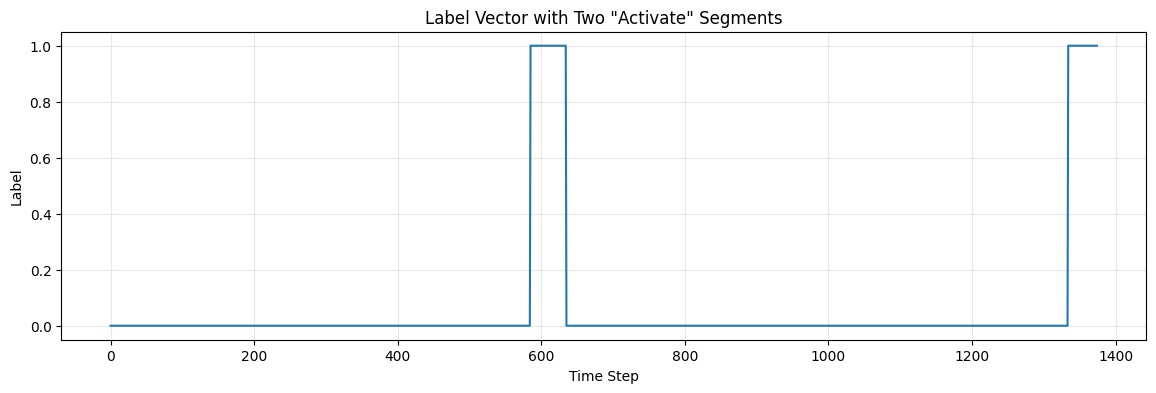

Sanity checks - y[1333]: 0.0, y[634]: 1.0, y[635]: 0.0


In [6]:
# ============================================================================
# SECTION 5: Label Generation
# ============================================================================

def insert_ones(y, segment_end_ms):
    """
    Update label vector: set 50 output steps after segment end to 1.
    
    Parameters:
        y (np.array): Label vector of shape (1, Ty)
        segment_end_ms (int): End time of segment in milliseconds
    
    Returns:
        np.array: Updated label vector
    """
    _, Ty = y.shape
    
    # Convert milliseconds to spectrogram time-steps
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Set next 50 steps to 1 (or until end of array)
        for i in range(segment_end_y + 1, min(segment_end_y + 51, Ty)):
            y[0, i] = 1
    
    return y


# Test label insertion
print("\nTesting label generation...")
Ty = 1375
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
arr1 = insert_ones(arr1, 4251)

plt.figure(figsize=(14, 4))
plt.plot(arr1[0, :])
plt.xlabel('Time Step')
plt.ylabel('Label')
plt.title('Label Vector with Two "Activate" Segments')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Sanity checks - y[1333]: {arr1[0, 1333]}, y[634]: {arr1[0, 634]}, y[635]: {arr1[0, 635]}")


CREATING SAMPLE TRAINING EXAMPLE
Spectrogram shape: (101, 5511)
Label shape: (1, 1375)


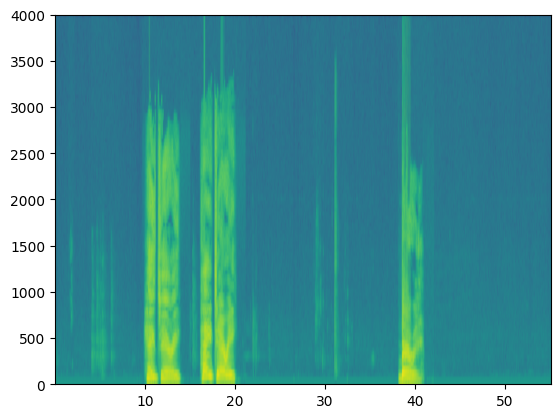

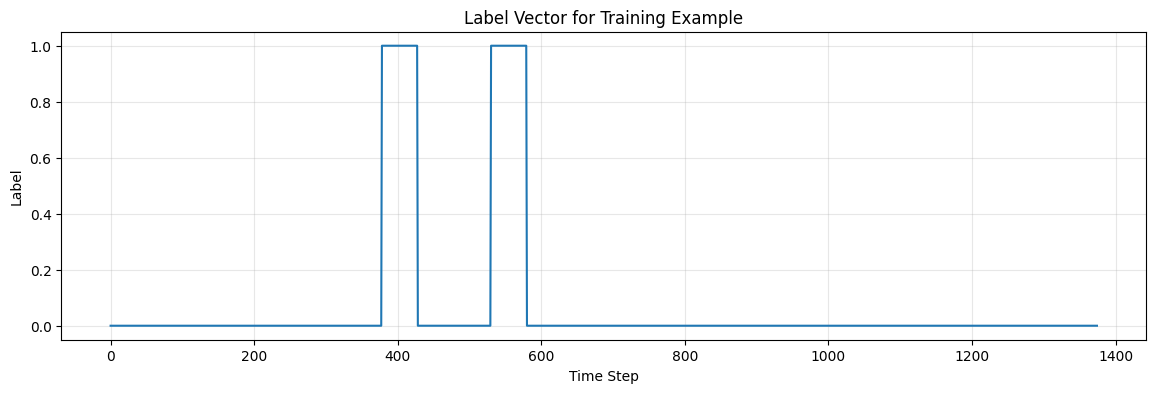

In [8]:
# ============================================================================
# SECTION 6: Training Example Creation
# ============================================================================

# Configuration
Tx = 5511  # Number of time steps in input spectrogram
Ty = 1375  # Number of time steps in output
N_FREQ = 101  # Number of frequency bins
SAMPLE_SIZE = 100  # Number of training samples to generate

def create_training_example(background, activates, negatives, Ty):
    """
    Creates a single training example by overlaying audio clips on background.
    
    Parameters:
        background (AudioSegment): 10-second background audio
        activates (list): List of "activate" audio clips
        negatives (list): List of negative word audio clips
        Ty (int): Number of time steps in output
    
    Returns:
        tuple: (x, y) - spectrogram and label vector
    """
    # Make background quieter
    background = background - 20
    
    # Initialize label vector and segment tracker
    y = np.zeros((1, Ty))
    previous_segments = []
    
    # Insert 0-2 random "activate" clips
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for one_random_activate in random_activates:
        background, segment_time = insert_audio_clip(
            background, one_random_activate, previous_segments
        )
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)
    
    # Insert 0-3 random negative clips
    number_of_negatives = np.random.randint(0, 4)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    
    for random_negative in random_negatives:
        background, _ = insert_audio_clip(
            background, random_negative, previous_segments
        )
    
    # Standardize volume
    background = match_target_amplitude(background, -20.0)
    
    # Export training example
    file_handle = background.export("../audio/generated/train.wav", format="wav")
    
    # Get spectrogram
    x = graph_spectrogram("../audio/generated/train.wav")
    
    return x, y


# Create a single example for visualization
print("\n" + "="*60)
print("CREATING SAMPLE TRAINING EXAMPLE")
print("="*60)
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

print(f"Spectrogram shape: {x.shape}")
print(f"Label shape: {y.shape}")

# Display audio
IPython.display.Audio("../audio/generated/train.wav")

# Plot label vector
plt.figure(figsize=(14, 4))
plt.plot(y[0])
plt.xlabel('Time Step')
plt.ylabel('Label')
plt.title('Label Vector for Training Example')
plt.grid(True, alpha=0.3)
plt.show()


GENERATING TRAINING DATASET
Processing sample 0/32...
Processing sample 10/32...
Processing sample 20/32...
Processing sample 30/32...

Training set shape: (32, 5511, 101)
Training labels shape: (32, 1375, 1)
✓ Training data saved!


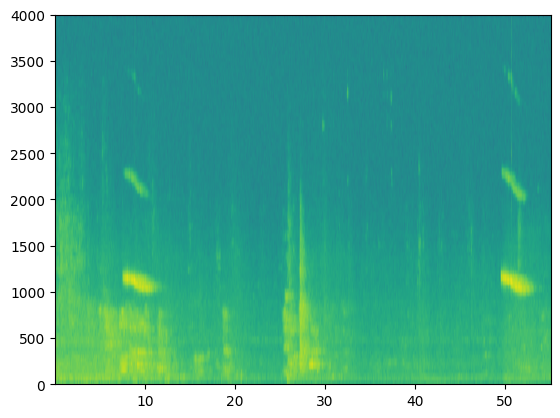

In [9]:
# ============================================================================
# SECTION 7: Generate Training Dataset
# ============================================================================

print("\n" + "="*60)
print("GENERATING TRAINING DATASET")
print("="*60)

np.random.seed(4543)
nsamples = 32
X_train = []
Y_train = []

for i in range(nsamples):
    if i % 10 == 0:
        print(f"Processing sample {i}/{nsamples}...")
    
    x, y = create_training_example(
        backgrounds[i % 2], activates, negatives, Ty
    )
    X_train.append(x.swapaxes(0, 1))
    Y_train.append(y.swapaxes(0, 1))

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")

# Save training data
np.save('../data/processed/train/X.npy', X_train)
np.save('../data/processed/train/Y.npy', Y_train)
print("✓ Training data saved!")


GENERATING DEVELOPMENT DATASET
Processing sample 0/4...

Development set shape: (4, 5511, 101)
Development labels shape: (4, 1375, 1)
✓ Development data saved!


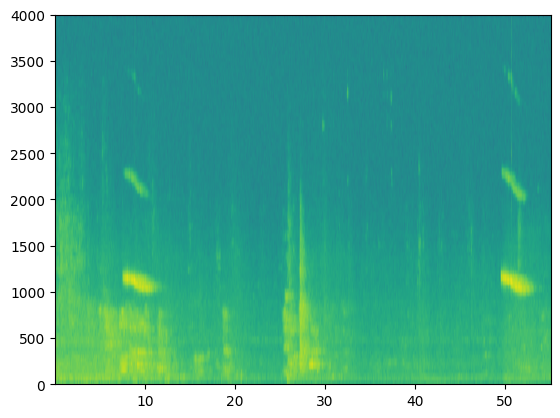

In [10]:
# ============================================================================
# SECTION 8: Generate Development Dataset
# ============================================================================

print("\n" + "="*60)
print("GENERATING DEVELOPMENT DATASET")
print("="*60)

np.random.seed(4543)
nsamples = 4
X_dev = []
Y_dev = []

for i in range(nsamples):
    if i % 10 == 0:
        print(f"Processing sample {i}/{nsamples}...")
    
    x, y = create_training_example(
        backgrounds[i % 2], activates, negatives, Ty
    )
    X_dev.append(x.swapaxes(0, 1))
    Y_dev.append(y.swapaxes(0, 1))

X_dev = np.array(X_dev)
Y_dev = np.array(Y_dev)

print(f"\nDevelopment set shape: {X_dev.shape}")
print(f"Development labels shape: {Y_dev.shape}")

# Save development data
np.save('../data/processed/dev/X.npy', X_dev)
np.save('../data/processed/dev/Y.npy', Y_dev)
print("✓ Development data saved!")

In [11]:
# ============================================================================
# SECTION 9: Verify Saved Data
# ============================================================================

print("\n" + "="*60)
print("VERIFYING SAVED DATA")
print("="*60)

# Load and verify training data
X_train_loaded = np.load("../data/processed/train/X.npy")
Y_train_loaded = np.load("../data/processed/train/Y.npy")
print(f"Training data: {X_train_loaded.shape}")
print(f"Training labels: {Y_train_loaded.shape}")

# Load and verify development data
X_dev_loaded = np.load("../data/processed/dev/X.npy")
Y_dev_loaded = np.load("../data/processed/dev/Y.npy")
print(f"Development data: {X_dev_loaded.shape}")
print(f"Development labels: {Y_dev_loaded.shape}")

print("\n" + "="*60)
print("DATA GENERATION COMPLETE!")
print("="*60)


VERIFYING SAVED DATA
Training data: (32, 5511, 101)
Training labels: (32, 1375, 1)
Development data: (4, 5511, 101)
Development labels: (4, 1375, 1)

DATA GENERATION COMPLETE!
